# Analysis Quality of Meals Restaurants By ML

In [85]:
import pandas as pd
import numpy as np
# from bidi.algorithm import get_display # the script can get a string as a parameter or read text from stdin
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # to perform Exploratory Data Analysis
import matplotlib.pyplot as plt
from PIL import Image
from bidi.algorithm import get_display
import arabic_reshaper #Reconstruct Arabic sentences to be used in applications that don't support Arabic script.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Arabic stopword
from nltk.corpus import stopwords
import nltk #For working with human languge
# nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import re #to provides regular expression matching operations similar to those found in Perl.
import string
import sys
import argparse
import emoji
from nltk.stem.isri import ISRIStemmer #Light Arabic stemming algorithm  
import itertools #To provide simlier feature based on iterartion
from sklearn import preprocessing
#from tashaphyne.stemming import ArabicLightStemmer
# classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, fbeta_score

import warnings
warnings.filterwarnings('ignore')

In [65]:
# !conda install -c conda-forge imbalanced-learn
# ! pip install -U imbalanced-learn
# ! pip install Tensorflow
! pip install arabicstopwords
nltk.download('stopwords')
! pip install emoji
! pip install transliterate

ERROR: Could not find a version that satisfies the requirement arabicstopwords (from versions: none)
ERROR: No matching distribution found for arabicstopwords
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [86]:
df = pd.read_csv('RES1.csv') #'arabic_dataset_classifiction.csv')
df.head(2)

,polarity,text,restaurant_id,user_id
0,-1,اولا: المنيو تغير الشورما اصبحت اعتياديه بأختف...,296,423
1,-1,من محلات الشاورما ذات الشعبيه لتميز الصلصات ال...,296,423


In [87]:
df.shape

(8364, 4)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8364 entries, 0 to 8363
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   polarity       8364 non-null   int64 
 1   text           8364 non-null   object
 2   restaurant_id  8364 non-null   int64 
 3   user_id        8364 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 261.5+ KB


In [89]:
df.isnull().sum()

polarity         0
text             0
restaurant_id    0
user_id          0
dtype: int64

In [90]:
datacloud = df['text']

In [31]:
all_words = []
for item in datacloud:
    w = nltk.tokenize.word_tokenize(item)
    all_words += w
len(all_words)

355092

### Visualization
- Collect all the word tokens in the text column: to compute how many tokens in the data, we have (355092) tokens.
- Then we have used one of the famous ways called (word cloud) to visualize the text data, to focused on words according to it's repeat times, in this steps 

In [28]:
def show_wordcloud(datacloud, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        font_path='arial',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(datacloud))

    fig = plt.figure(1, figsize=(12, 12), dpi=300)
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

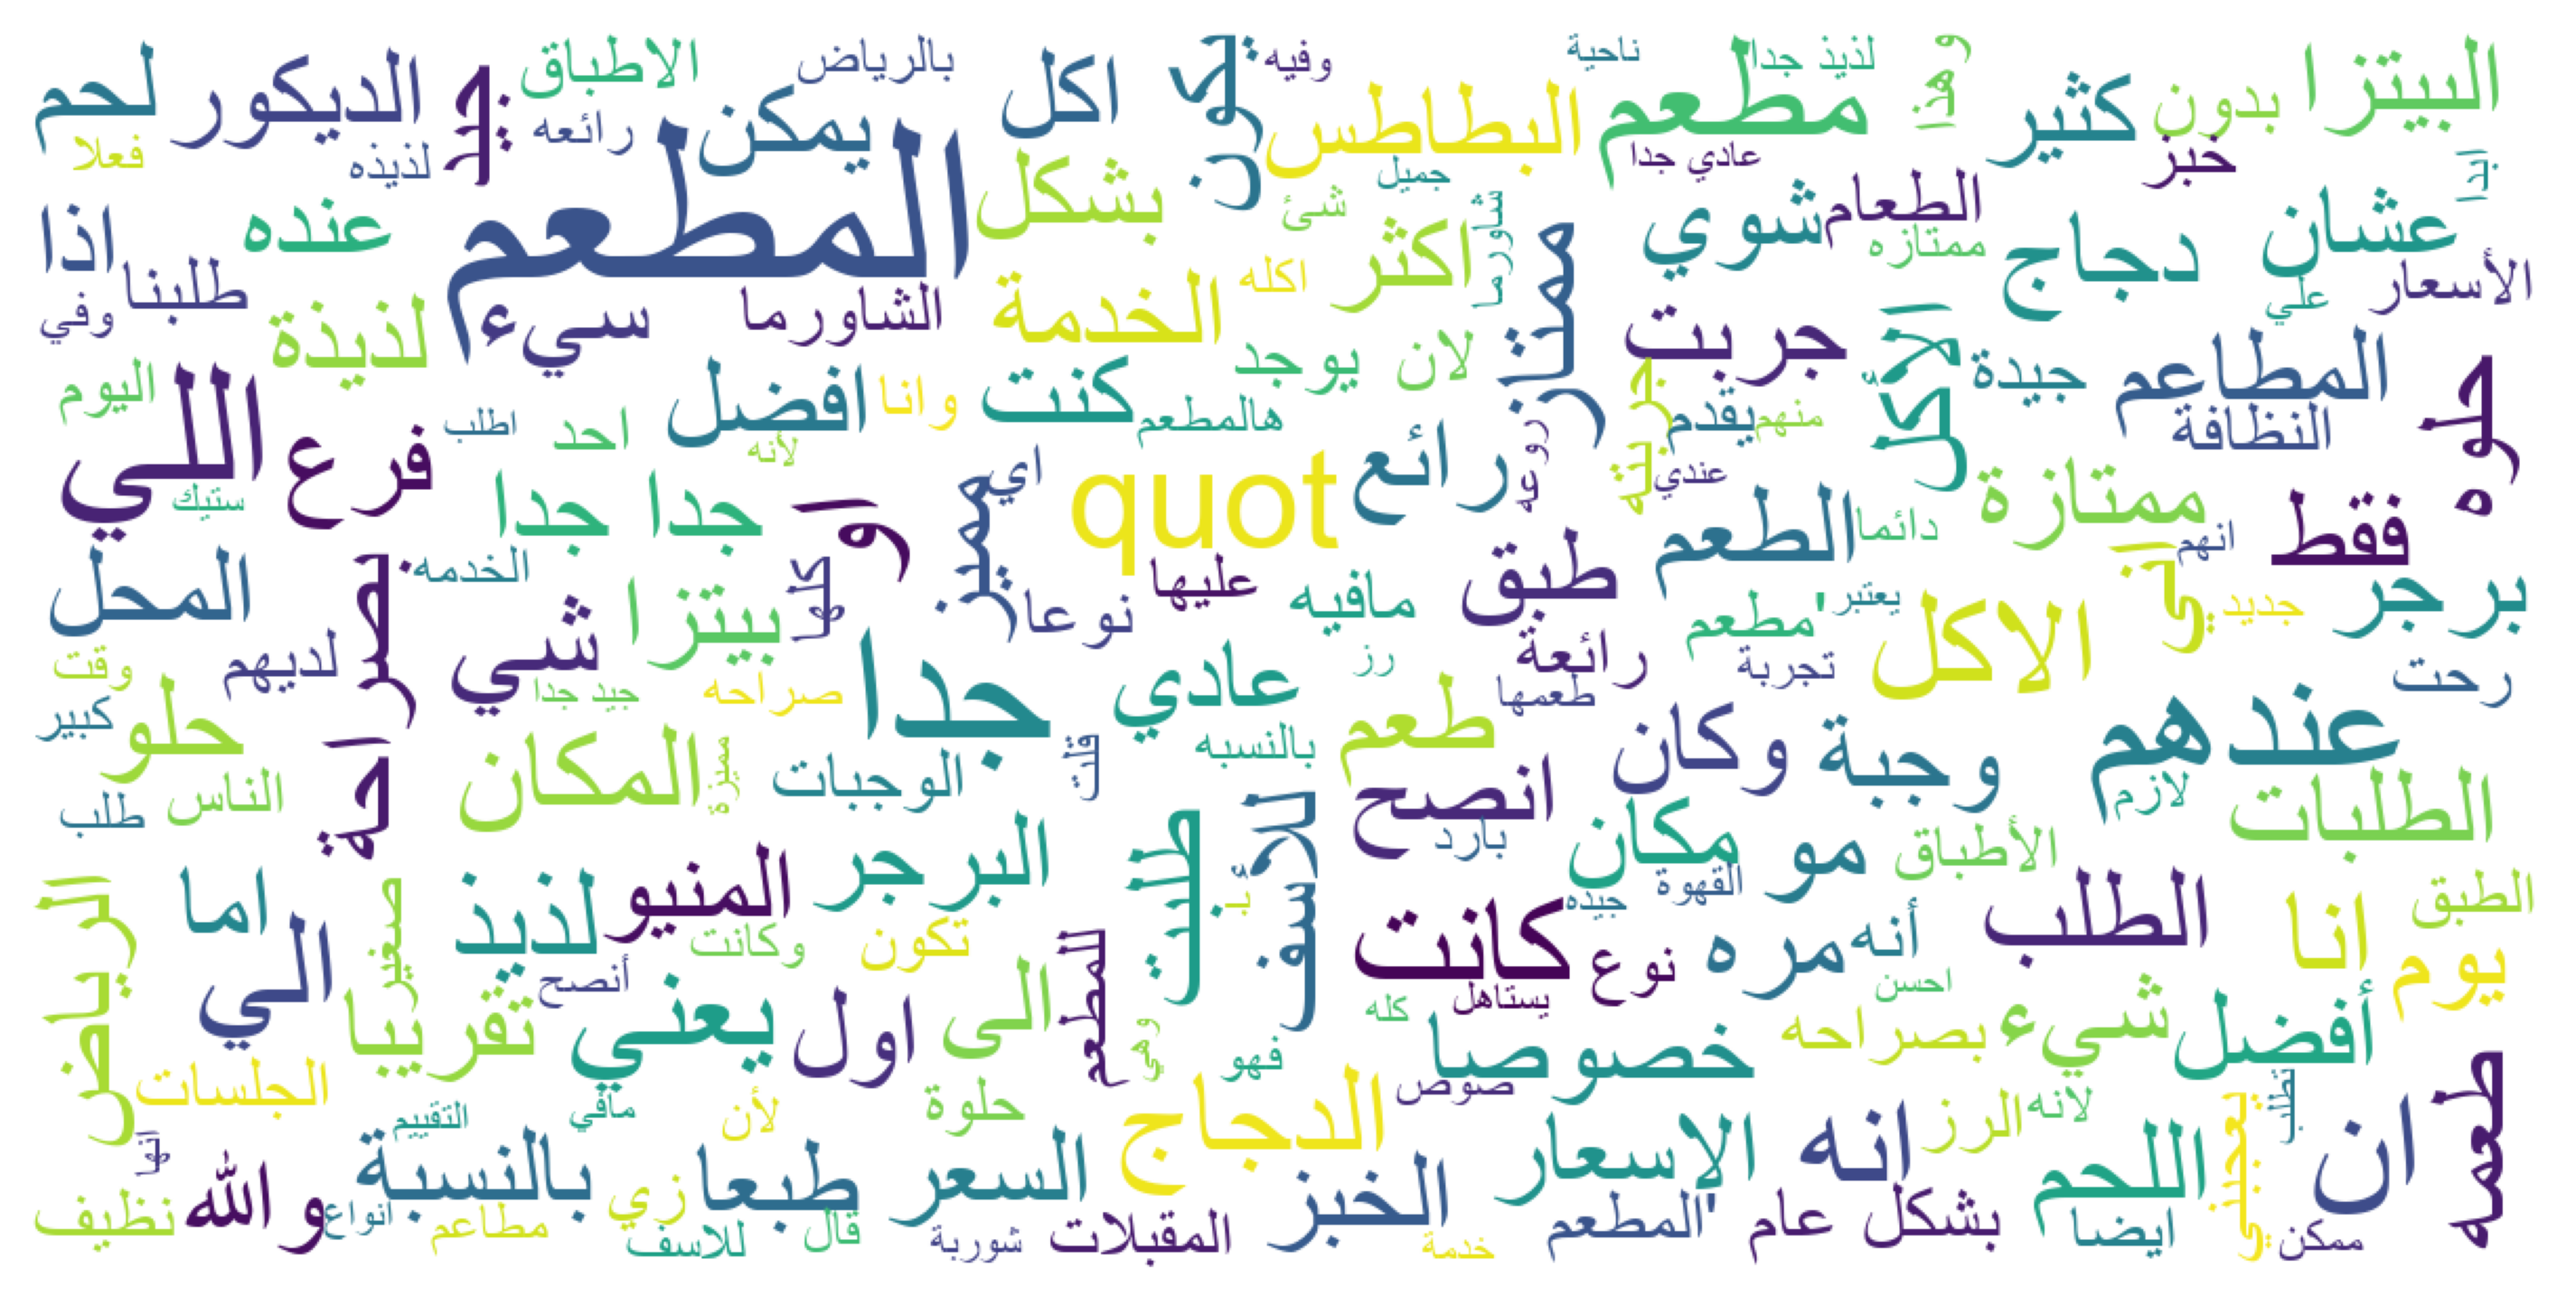

In [29]:
stopwords = set(nltk.corpus.stopwords.words("arabic"))
stopwords.update({'على', "الا", "ولا", "'"})
sw = []
for item in stopwords:
    sw.append(get_display(arabic_reshaper.reshape(item)))
stopwords = sw
   
x = []
for item in datacloud:
    x.append(get_display(arabic_reshaper.reshape(item)))

show_wordcloud(x)

## Pre-processing
- Data cleaning
 - Drop the duplicate values.
 - Remove stop words.
 - Remove the stop words.
 - Remove punctuations.
 - Normalize arabic text.
 - Remove emojis.
 - Remove repeating char.
 - Stemming.
 - ProcessPost for applying all functions. 

### Drop the duplicate values 

In [91]:
# The number of duplicates 
print("The number of duplicates: ", df.duplicated(subset=None, keep='first').sum())
print("The number of after drop duplicates: ", df.drop_duplicates(inplace=True))
# the number of non-duplicates 
print("The number rows of non-duplicates: ", (~df.duplicated()).sum())

The number of duplicates:  36
The number of after drop duplicates:  None
The number rows of non-duplicates:  8328


In [92]:
def emoji_counter(sentence):
    return emoji.emoji_count(sentence)

df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df['text'].str.len() ## this also includes spaces
stop = stopwords.words('arabic')
df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df['emoji_count'] = df['text'].apply(lambda x: emoji_counter(x))
df = df.sort_values(by='word_count',ascending=[0])
df.head(10) 

,polarity,text,restaurant_id,user_id,word_count,char_count,stopwords,emoji_count
2245,1,زيراتي للمطاعم عادتآ تكون بتخطيط مسبق لكن الزي...,2038,3690,912,4742,105,0
102,1,"المطعم يستخدم نظام البوصة, حيث أن أغلب وجباته ...",68,5231,890,4246,58,0
4903,-1,بسم الله \n وصلى الله وسلم على رسول الله \n ...,1986,4446,846,4250,128,0
6232,-1,هذ التقييم لفرع التحلية \n \n المكسيكين ضيافت...,1956,3690,796,4118,101,0
4335,1,السلام عليكم \n \n اليوم قررت اني اخذ العيال...,2108,4446,746,3638,110,0
5117,1,السلام عليكم \n \n تقييمي راح يكون كالاتي \...,1350,3690,673,3578,102,0
5060,-1,اليوم حبيت أكل شي صيني \n فجلست افكر بكم محل \...,1981,4614,621,2930,102,0
6233,1,مطعم الشيكو \n من مدة ما تكلمت عن المطاعم \n ...,1956,38204,577,2457,74,0
6309,1,السلام عليكم،، \n بالنسبة لي ، فزياراتي متكررة...,41,4295,573,2737,89,0
6163,-1,بالبداية لم أعرف كيف أو ماذا سأكتب عن هذ المطع...,2151,3690,552,3028,99,0


# 

### Remove the unwanted words (stop words) 

In [93]:
all_stopwords = stopwords.words('arabic')
all_stopwords

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [94]:
print(len(all_stopwords))

754


In [95]:
listToStr = ' '.join([str(elem) for elem in all_stopwords])
listToStr

'إذ إذا إذما إذن أف أقل أكثر ألا إلا التي الذي الذين اللاتي اللائي اللتان اللتيا اللتين اللذان اللذين اللواتي إلى إليك إليكم إليكما إليكن أم أما أما إما أن إن إنا أنا أنت أنتم أنتما أنتن إنما إنه أنى أنى آه آها أو أولاء أولئك أوه آي أي أيها إي أين أين أينما إيه بخ بس بعد بعض بك بكم بكم بكما بكن بل بلى بما بماذا بمن بنا به بها بهم بهما بهن بي بين بيد تلك تلكم تلكما ته تي تين تينك ثم ثمة حاشا حبذا حتى حيث حيثما حين خلا دون ذا ذات ذاك ذان ذانك ذلك ذلكم ذلكما ذلكن ذه ذو ذوا ذواتا ذواتي ذي ذين ذينك ريث سوف سوى شتان عدا عسى عل على عليك عليه عما عن عند غير فإذا فإن فلا فمن في فيم فيما فيه فيها قد كأن كأنما كأي كأين كذا كذلك كل كلا كلاهما كلتا كلما كليكما كليهما كم كم كما كي كيت كيف كيفما لا لاسيما لدى لست لستم لستما لستن لسن لسنا لعل لك لكم لكما لكن لكنما لكي لكيلا لم لما لن لنا له لها لهم لهما لهن لو لولا لوما لي لئن ليت ليس ليسا ليست ليستا ليسوا ما ماذا متى مذ مع مما ممن من منه منها منذ مه مهما نحن نحو نعم ها هاتان هاته هاتي هاتين هاك هاهنا هذا هذان هذه هذي هذين هكذا هل هلا هم هما هن هنا هن

In [96]:
def remove_stop_words(text):
    all_stopwords = list(set(stopwords.words("arabic"))) + pd.read_csv('Stopwords.txt').iloc[:,0].values.tolist()
    needed_words = []
    words = nltk.tokenize.word_tokenize(text)
    for w in words:
        if w not in all_stopwords and len(w) >= 2:
            needed_words.append(w)
            # join the list of  words without stop words, as shown below:
    filtered_sentence = " ".join(needed_words)# " ".join(needed_words)
    return filtered_sentence # " ".join(needed_words)

df["cleaned_text"] = df["text"].apply(lambda text : remove_stop_words(text))

### Remove punctuations 

In [97]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df["cleaned_text"] = df["cleaned_text"].apply(lambda text : remove_punctuations(text))

### Remove emojis 

In [98]:
# https://gist.github.com/bfeldman89/fb25ddb63bdaa6de6ab7ac946acde96f#file-emojis-csv
# https://github.com/motazsaad/process-arabic-text/blob/master/clean_arabic_text.py
def remove_emoji(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"                        
         "]+", flags = re.UNICODE) # VERBOSE
    return regrex_pattern.sub(r'',text)

df["cleaned_text"] = df["cleaned_text"].apply(lambda text : remove_emoji(text))

### Normalize arabic text 

In [99]:
def noramlize(text):
    text = re.sub(r"[إأٱآا]", "ا", text)
    text = re.sub(r"ى", "ي", text)
    text = re.sub(r"ؤ", "ء", text)
    text = re.sub(r"ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    text = re.sub(r'[^ا-ي ]', "", text)

    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    return text

df["cleaned_text"] = df["cleaned_text"].apply(lambda text : noramlize(text))

### Remove repeating char 

In [100]:
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

df["cleaned_text"] = df["cleaned_text"].apply(lambda text : remove_repeating_char(text))

## Stemming-- ISRIStemmer :

In [101]:
def stemming(text):
    st = ISRIStemmer()
    stemmed_words = []
    words = word_tokenize(text)
    for w in words:
        stemmed_words.append(st.stem(w))
    stemmed_sentence = " ".join(stemmed_words)
    return stemmed_sentence

df["cleaned_text"] = df["cleaned_text"].apply(lambda text : stemming(text))

### ProcessPost for applying all functions 

In [102]:
def processPost(text): 

    #Replace @username with empty string
    #text = re.sub('@[^\s]+', ' ', text)
    
    # remove extra whitespace
    text = re.sub('\s+', ' ', text)
    
    # Remove numbers
    text = re.sub("\d+", " ", text)
    
    #Convert www.* or https?://* to " "
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text, flags=re.MULTILINE)
    text = re.sub(r'^http?:W.[\r\n]',' ', text, flags=re.MULTILINE)
    
    #Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)
    
    text = re.sub('[A-Za-z]+',' ',text)
    text = re.sub(r'\\u[A-Za-z0-9\\]+',' ',text)
    
    return text

df["cleaned_text"] = df["cleaned_text"].apply(lambda text : processPost(text))

In [103]:
def prepare(text):
    text = remove_stop_words(text)
    text = remove_punctuations(text)
    #text = "".join([w for w in words if w not in string.punctuation])
    txet = noramlize(text)
    text = remove_emoji(text)
    text = stemming(text)
    tokens = word_tokenize(text)
    text = remove_repeating_char(text)
    text = processPost(text)
    # text = ' '.join([word for word in tokens if word not in stop_words])
    return text

df["cleaned_text"] = df["cleaned_text"].apply(lambda text : prepare(text))

In [104]:
# Instantiate CountVectorizer
cv = CountVectorizer()
# Fit the text with CountVectorizer
bow_restaurant = cv.fit(df.cleaned_text)
bow_restaurant_t = bow_restaurant.transform(df.cleaned_text)
# Define dataframe that contains the frequency of words in each text
count_vect_df = pd.DataFrame(bow_restaurant_t.todense(), columns=bow_restaurant.get_feature_names())

In [105]:
# Define dataframe that contains the sum of words frequency 
sum_df = pd.DataFrame(np.sum(bow_restaurant_t.todense(),axis=0), columns=cv.get_feature_names())

# Sort by the frequency of words of first 20 common words
sum_df.sort_values(by=0, ascending=False, axis=1).iloc[:,:30]

,طعم,اكل,طلب,سعر,جرب,مره,لذ,فضل,خدم,دج,...,عجب,جلس,كثر,صرح,شكل,عدي,تاز,نصح,يتز,رجر
0,9669,3116,2951,2743,2468,1909,1894,1679,1660,1594,...,1083,1080,1059,1026,964,932,928,894,884,862


In [106]:
df.to_csv("Final_RES1.csv", encoding="utf-8")

### ===============================================================================
### ===============================================================================

In [107]:
df2 = pd.read_csv('Final_RES1.csv') 
df2.head()

,Unnamed: 0,polarity,text,restaurant_id,user_id,word_count,char_count,stopwords,emoji_count,cleaned_text
0,2245,1,زيراتي للمطاعم عادتآ تكون بتخطيط مسبق لكن الزي...,2038,3690,912,4742,105,0,زير طعم عدت خط سبق زير زرت طعم كنو خرج خط تما ...
1,102,1,"المطعم يستخدم نظام البوصة, حيث أن أغلب وجباته ...",68,5231,890,4246,58,0,طعم خدم نظم بوص غلب وجب تي قسم بوص وتع نصف سان...
2,4903,-1,بسم الله \n وصلى الله وسلم على رسول الله \n ...,1986,4446,846,4250,128,0,بسم اله وصل اله سلم رسل اله شب قيمو طعم خلو وق...
3,6232,-1,هذ التقييم لفرع التحلية \n \n المكسيكين ضيافت...,1956,3690,796,4118,101,0,هذ تقم فرع حله كسك ضيف ضيف يزه خص بيت ضيف يحي ...
4,4335,1,السلام عليكم \n \n اليوم قررت اني اخذ العيال...,2108,4446,746,3638,110,0,سلم قرت اني اخذ عيل طلع طعم سمك جرب ويض كتب تق...


In [108]:
# Displays a sample of rows in the dataframe
df2.sample(5, random_state=42)

,Unnamed: 0,polarity,text,restaurant_id,user_id,word_count,char_count,stopwords,emoji_count,cleaned_text
3534,3292,1,"على شارع التحلية, بين الريف الايطالي والريف ال...",157,5,34,188,8,0,حله ريف يطل ريف قسم عال فرد طقم خدم حرف ريدو ب...
1618,7670,1,+ اسعار معقولة ( على الرغم بأنه بدأ يرفع اسعار...,1689,6085,70,275,7,0,سعر عقل رغم بنه بدا رفع سعر اخذ شهر طعم تاز اك...
8100,8261,1,مررررره لذيذ,1594,25318,3,13,0,0,مره لذ
2851,6134,1,المطعم داااااااااااااهية .. \n وخصوصا .. الادا...,294,7585,43,175,1,0,طعم دهي خص ادم وذا خبص تمس وي وي وي خرف اوب سح...
5498,885,1,الصراحة المطعم ماعليه غبار .. بس فيه مشكله وحد...,161,29573,17,85,3,0,صرح طعم اعل غبر شكل وحد اخر وصل طلب


In [109]:
df2.shape

(8328, 10)

In [110]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8328 entries, 0 to 8327
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     8328 non-null   int64 
 1   polarity       8328 non-null   int64 
 2   text           8328 non-null   object
 3   restaurant_id  8328 non-null   int64 
 4   user_id        8328 non-null   int64 
 5   word_count     8328 non-null   int64 
 6   char_count     8328 non-null   int64 
 7   stopwords      8328 non-null   int64 
 8   emoji_count    8328 non-null   int64 
 9   cleaned_text   8275 non-null   object
dtypes: int64(8), object(2)
memory usage: 650.8+ KB


### Missing values:  

In [111]:
df2.isnull().sum().sort_values(ascending=False) 

cleaned_text     53
Unnamed: 0        0
polarity          0
text              0
restaurant_id     0
user_id           0
word_count        0
char_count        0
stopwords         0
emoji_count       0
dtype: int64

In [112]:
df2.dropna(how = 'any', inplace=True)

In [113]:
df2.isnull().sum().sort_values(ascending=False)

Unnamed: 0       0
polarity         0
text             0
restaurant_id    0
user_id          0
word_count       0
char_count       0
stopwords        0
emoji_count      0
cleaned_text     0
dtype: int64

#### - In the beginning, the number of words was 355092, after processing the Arabic text, the number of words we have became 220256, meaning that approximately 134836 an element was deleted

In [114]:
all_words = []
for item in df2.cleaned_text:
    w = nltk.tokenize.word_tokenize(str(item))
    all_words += w
len(all_words)

220203

## Pre-processing

### Droping colunams 

In [115]:
# Droping colunams
df2.drop(labels= ['Unnamed: 0', 'word_count', 'char_count', 'stopwords', 'emoji_count'], axis=1 , inplace=True)
df2.head(1)

,polarity,text,restaurant_id,user_id,cleaned_text
0,1,زيراتي للمطاعم عادتآ تكون بتخطيط مسبق لكن الزي...,2038,3690,زير طعم عدت خط سبق زير زرت طعم كنو خرج خط تما ...


### Drop the duplicate values

In [116]:
 # The number of duplicates 
print("The number of duplicates: ", df2.duplicated(subset=None, keep='first').sum())

The number of duplicates:  0


In [117]:
df2.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
polarity,8275.0,NaN,NaN,NaN,0.420423,0.907383,-1.0,-1.0,1.0,1.0,1.0
text,8275,8247,لذيذ,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
restaurant_id,8275.0,NaN,NaN,NaN,925.005801,1111.796307,32.0,150.5,456.0,1392.0,5182.0
user_id,8275.0,NaN,NaN,NaN,13658.853897,12966.109153,5.0,2199.0,6834.0,25883.0,42384.0
cleaned_text,8275,8187,لذ,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
df2['cleaned_text']= df2.cleaned_text.str.strip() # saved in the memory (ie, memory change)

In [119]:
yy= df2.polarity.value_counts()
yy

 1    5877
-1    2398
Name: polarity, dtype: int64

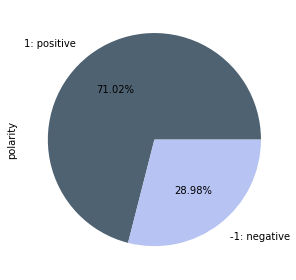

In [120]:
colors = ['#4F6272', '#B7C3F3']
labels = ("1: positive ", "-1: negative")
yy.plot.pie(labels =labels, labeldistance=1.15, autopct=lambda p:f'{p:.2f}%', colors=colors)
plt.title('', fontsize=20)
plt.tight_layout()
plt.show()

### Split the data into 80% train and 20% test. 

In [121]:
X = df2["cleaned_text"]
y = df2["polarity"]

In [122]:
X.isnull().sum()

0

## Feature Extraction
### Vectorize the text data using the Count Vectorizer and Tfidf Vectorizer 

In [123]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize a CountVectorizer object: cv
cv = CountVectorizer(stop_words= all_stopwords)

In [124]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state = 42)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (6620,)
X_test: (1655,)
y_train: (6620,)
y_test: (1655,)


In [125]:
# Encode the text
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

cv.get_feature_names_out()

array(['اب', 'ابا', 'اباتايزر', ..., 'يوف', 'يول', 'يون'], dtype=object)

In [126]:
print("Encoded text is:")
X_train_cv.toarray()

Encoded text is:


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [127]:
X_test_cv.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [128]:
# Initialize a TFIDF object: tf
tf = TfidfVectorizer(ngram_range = (1,2), stop_words=all_stopwords)
X_train_tf = tf.fit_transform(X_train)
X_test_tf = tf.transform(X_test)

## Supervised - Classification
###  Building the learning function Classification

In [129]:
def model_eval(mdl_local, X_local, y_local, eval_name = "Train", bta=1):
    
    y_pred = mdl_local.predict(X_local)
    
    print(f"________________ {eval_name} Metrics______________")
    acc = mdl_local.score(X_local , y_local)
    print("Accuarcy score:", acc)
    prec = precision_score(y_local, y_pred )
    print("Precision Score:", prec)
    recall = recall_score(y_local, y_pred)
    print("Recall Score:", recall)
    fbta = fbeta_score( y_local, y_pred, beta=bta)
    print(f"F{bta} Score:", fbta)
    
    return {f"{eval_name}_acc":acc, f"{eval_name}_prec":prec, f"{eval_name}_recall":recall, f"{eval_name}_fbta":fbta}
    
    
def modeling(expr_name, mdl_local, X_train_local, y_train_local, X_test_local, y_test_local):

    mdl_local.fit(X_train_local, y_train_local)
    print(f"################### {expr_name} ###################")
    expr_metric_dict = model_eval(mdl_local, X_train_local, y_train_local, eval_name = "Train", bta=1)
    expr_metric_dict.update(model_eval(mdl_local, X_test_local, y_test_local, eval_name = "Test", bta=1))
    
    expr_metric_dict["expr_name"] = expr_name
    
    return mdl_local, expr_metric_dict

def make_exprs(exprs_local: list):
    exprs = exprs_local
    list_metics = []
    list_models = []
    for model, metric in exprs:
        list_models.append(model)
        list_metics.append(metric)
    return list_models, pd.DataFrame(list_metics)

In [130]:
import sklearn
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier #Provide supervised and unsupervised algorithms 
from sklearn.svm import SVC, LinearSVC #To fit the data and to divid and categorize the data
# NuSVC

models, metric_df = make_exprs([    modeling("LogisticRegression with CV", LogisticRegression(), 
                                             X_train_cv, y_train, X_test_cv, y_test),
                                    modeling("LogisticRegression with TFIDF", LogisticRegression(),
                                             X_train_tf, y_train, X_test_tf, y_test),
                                    modeling("MultinomialNB with CV", MultinomialNB(),
                                             X_train_cv, y_train, X_test_cv, y_test),
                                    modeling("MultinomialNB with TFIDf", MultinomialNB(),
                                             X_train_tf, y_train, X_test_tf, y_test),
                                
                                    modeling("BernoulliNB with CV", BernoulliNB(), 
                                             X_train_cv, y_train, X_test_cv, y_test),
                                    modeling("BernoulliNB with TFIDF", BernoulliNB(),
                                             X_train_tf, y_train, X_test_tf, y_test),
                                
                                    modeling("SGDClassifier with CV",SGDClassifier(), 
                                             X_train_cv, y_train, X_test_cv, y_test),
                                    modeling("SGDClassifier with TFIDF", SGDClassifier(),
                                             X_train_tf, y_train, X_test_tf, y_test),
                                
                                    modeling("SVC with CV", SVC(), 
                                             X_train_cv, y_train, X_test_cv, y_test),
                                    modeling("SVC with TFIDF", SVC(),
                                             X_train_tf, y_train, X_test_tf, y_test),
                                
                                    modeling("LinearSVC with CV", LinearSVC(), 
                                             X_train_cv, y_train, X_test_cv, y_test),
                                    modeling("LinearSVC with TFIDF", LinearSVC(),
                                             X_train_tf, y_train, X_test_tf, y_test)
                                    
                                    ])

################### LogisticRegression with CV ###################
________________ Train Metrics______________
Accuarcy score: 0.9477341389728097
Precision Score: 0.9436762911752745
Recall Score: 0.9853503184713376
F1 Score: 0.9640631491483174
________________ Test Metrics______________
Accuarcy score: 0.8308157099697885
Precision Score: 0.8579499596448749
Recall Score: 0.9108826049700086
F1 Score: 0.8836242726517041
################### LogisticRegression with TFIDF ###################
________________ Train Metrics______________
Accuarcy score: 0.8915407854984895
Precision Score: 0.8708658491267187
Recall Score: 0.9951167728237792
F1 Score: 0.9288545382481173
________________ Test Metrics______________
Accuarcy score: 0.8283987915407856
Precision Score: 0.8210909090909091
Recall Score: 0.9674378748928878
F1 Score: 0.8882769472856019
################### MultinomialNB with CV ###################
________________ Train Metrics______________
Accuarcy score: 0.8957703927492447
Precision S

In [131]:
metric_df

,Train_acc,Train_prec,Train_recall,Train_fbta,Test_acc,Test_prec,Test_recall,Test_fbta,expr_name
0,0.947734,0.943676,0.985350,0.964063,0.830816,0.857950,0.910883,0.883624,LogisticRegression with CV
1,0.891541,0.870866,0.995117,0.928855,0.828399,0.821091,0.967438,0.888277,LogisticRegression with TFIDF
2,0.895770,0.902322,0.957113,0.928910,0.830211,0.847179,0.926307,0.884977,MultinomialNB with CV
3,0.753474,0.742668,1.000000,0.852334,0.714804,0.712279,0.999143,0.831669,MultinomialNB with TFIDf
4,0.821148,0.827209,0.946285,0.882749,0.766767,0.784829,0.922022,0.847912,BernoulliNB with CV
5,0.805438,0.788533,0.992781,0.878947,0.719637,0.718459,0.990574,0.832853,BernoulliNB with TFIDF
6,0.972810,0.972860,0.989384,0.981053,0.810876,0.860642,0.873179,0.866865,SGDClassifier with CV
7,0.992447,0.992184,0.997240,0.994706,0.844713,0.865756,0.922879,0.893405,SGDClassifier with TFIDF
8,0.915106,0.901316,0.988960,0.943106,0.810876,0.808526,0.958869,0.877303,SVC with CV
9,0.993505,0.992196,0.998726,0.995450,0.835045,0.831111,0.961440,0.891538,SVC with TFIDF


### SMOTE for handle imbalanced datasets 

In [132]:
# !conda install -c conda-forge imbalanced-learn
! pip install -U imbalanced-learn
#! pip install imblearn

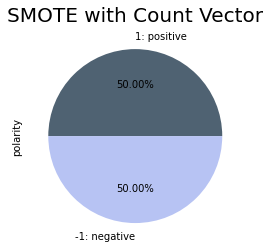

In [133]:
from imblearn.over_sampling import SMOTE
from imblearn import over_sampling

smote = SMOTE(sampling_strategy='minority', random_state = 42)
#smote=imblearn.over_sampling.SMOTE(sampling_strategy='minority', random_state = 42)   
X_tr_smoteCV, y_tr_smoteCV = smote.fit_resample(X_train_cv, y_train)

ax = y_tr_smoteCV.value_counts().plot.pie(labels = labels, labeldistance=1.15, autopct=lambda p:f'{p:.2f}%', colors=colors)
_ = ax.set_title("SMOTE with Count Vector", fontsize=20)


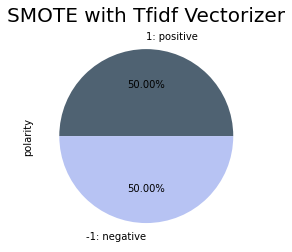

In [134]:
smote1 = SMOTE(sampling_strategy='minority', random_state = 42)
#smote=imblearn.over_sampling.SMOTE(sampling_strategy='minority', random_state = 42)   
X_tr_smoteTF, y_tr_smoteTF = smote.fit_resample(X_train_tf, y_train)

ax1 = y_tr_smoteTF.value_counts().plot.pie(labels = labels, labeldistance=1.15, autopct=lambda p:f'{p:.2f}%', colors=colors)
_ = ax1.set_title("SMOTE with Tfidf Vectorizer", fontsize=20)

In [135]:
models, metric_df = make_exprs([    modeling("LogisticRegression with CV", LogisticRegression(), 
                                             X_tr_smoteCV, y_tr_smoteCV, X_test_cv, y_test),
                                    modeling("LogisticRegression with TFIDF", LogisticRegression(),
                                             X_tr_smoteTF, y_tr_smoteTF, X_test_tf, y_test),
                                    modeling("MultinomialNB with CV", MultinomialNB(),
                                             X_tr_smoteCV, y_tr_smoteCV, X_test_cv, y_test),
                                    modeling("MultinomialNB with TFIDf", MultinomialNB(),
                                             X_tr_smoteTF, y_tr_smoteTF, X_test_tf, y_test),
                                
                                    modeling("BernoulliNB with CV", BernoulliNB(), 
                                             X_tr_smoteCV, y_tr_smoteCV, X_test_cv, y_test),
                                    modeling("BernoulliNB with TFIDF", BernoulliNB(),
                                             X_tr_smoteTF, y_tr_smoteTF, X_test_tf, y_test),
                                
                                    modeling("SGDClassifier with CV",SGDClassifier(), 
                                             X_tr_smoteCV, y_tr_smoteCV, X_test_cv, y_test),
                                    modeling("SGDClassifier with TFIDF", SGDClassifier(),
                                            X_tr_smoteTF, y_tr_smoteTF, X_test_tf, y_test),
                                
                                    modeling("SVC with CV", SVC(), 
                                             X_tr_smoteCV, y_tr_smoteCV, X_test_cv, y_test),
                                    modeling("SVC with TFIDF", SVC(),
                                             X_tr_smoteTF, y_tr_smoteTF, X_test_tf, y_test),
                                
                                    modeling("LinearSVC with CV", LinearSVC(), 
                                             X_tr_smoteCV, y_tr_smoteCV, X_test_cv, y_test),
                                    modeling("LinearSVC with TFIDF", LinearSVC(),
                                             X_tr_smoteTF, y_tr_smoteTF, X_test_tf, y_test)
                                    
                                    ])

################### LogisticRegression with CV ###################
________________ Train Metrics______________
Accuarcy score: 0.9363057324840764
Precision Score: 0.9554521276595744
Recall Score: 0.9152866242038217
F1 Score: 0.9349381912817175
________________ Test Metrics______________
Accuarcy score: 0.8018126888217523
Precision Score: 0.8859245630174793
Recall Score: 0.8251928020565553
F1 Score: 0.8544809228039042
################### LogisticRegression with TFIDF ###################
________________ Train Metrics______________
Accuarcy score: 0.9656050955414013
Precision Score: 0.9616842105263158
Recall Score: 0.9698513800424629
F1 Score: 0.9657505285412262
________________ Test Metrics______________
Accuarcy score: 0.8398791540785498
Precision Score: 0.8887931034482759
Recall Score: 0.8834618680377035
F1 Score: 0.8861194671250537
################### MultinomialNB with CV ###################
________________ Train Metrics______________
Accuarcy score: 0.8881104033970276
Precision S

In [136]:
metric_df

,Train_acc,Train_prec,Train_recall,Train_fbta,Test_acc,Test_prec,Test_recall,Test_fbta,expr_name
0,0.936306,0.955452,0.915287,0.934938,0.801813,0.885925,0.825193,0.854481,LogisticRegression with CV
1,0.965605,0.961684,0.969851,0.965751,0.839879,0.888793,0.883462,0.886119,LogisticRegression with TFIDF
2,0.888110,0.872150,0.909554,0.890459,0.833233,0.887728,0.874036,0.880829,MultinomialNB with CV
3,0.985669,0.992253,0.978981,0.985572,0.847734,0.905945,0.874893,0.890148,MultinomialNB with TFIDf
4,0.723036,0.817084,0.574735,0.674810,0.590332,0.792814,0.567266,0.661339,BernoulliNB with CV
5,0.856582,0.777557,0.998938,0.874454,0.739577,0.744032,0.961440,0.838879,BernoulliNB with TFIDF
6,0.956900,0.969664,0.943312,0.956307,0.794562,0.878317,0.822622,0.849558,SGDClassifier with CV
7,0.993843,0.994683,0.992994,0.993838,0.843505,0.876451,0.905741,0.890855,SGDClassifier with TFIDF
8,0.921125,0.942055,0.897452,0.919213,0.776435,0.839149,0.844901,0.842015,SVC with CV
9,0.997452,0.997452,0.997452,0.997452,0.836858,0.833457,0.960583,0.892516,SVC with TFIDF


In [3]:
#from sklearn.metrics import classification_report
#print (classification_report(y_test, y_pred))

# make prediction and print accuracy
#prediction = model.predict(X_test)
#print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
#print(classification_report(Y_test, prediction))

## K-Means Unsupervised Sentiment Analysis

In [73]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
seed = 0

### Converting the text into vectors using TdidfVectorizer

In [74]:
# Tfidf Vectorizer
tf2 = TfidfVectorizer()
# Fit transform the data
X2 =tf2.fit_transform(df2['cleaned_text'].values)

In [75]:
for i, feature in enumerate(tf2.get_feature_names()[:10]):
    print(i, feature)

0 اب
1 ابا
2 اباتايزر
3 ابالنسبه
4 ابت
5 ابتسامتي
6 ابتكاريه
7 ابث
8 ابخ
9 ابد


In [76]:
scaler = StandardScaler(with_mean=False)
scaled= scaler.fit_transform(X2)
scaled

<8275x8690 sparse matrix of type '<class 'numpy.float64'>'
	with 184951 stored elements in Compressed Sparse Row format>

In [77]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=256, batch_size=512, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters


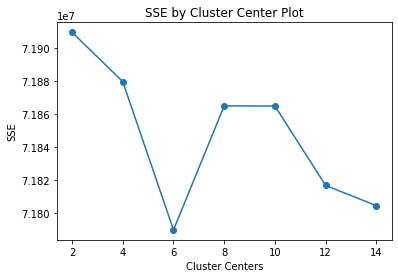

In [78]:
find_optimal_clusters(scaled, 15)

In [79]:
clusters = MiniBatchKMeans(n_clusters=4, init_size=1024, batch_size=2048, random_state=20).fit_predict(scaled)

### - This is what we built on 4 clusters which was efficient now let's form on 3 clusters (Positive, Negative and Neutral)

In [80]:
clusters = MiniBatchKMeans(n_clusters=3, init_size=1024, batch_size=2048, random_state=20).fit_predict(scaled)

In [2]:
#clusters1 = MiniBatchKMeans(n_clusters=3, init_size=1024, batch_size=2048, random_state=20)
#clusters1.fit(scaled)

#plt.figure(figsize=(10,5))
#scatter = plt.scatter(y= scaled[:, 0], x=scaled[:,1], c= clusters1.labels_)
#plt.xlabel('')
#plt.ylabel('')
#plt.legend(handles=scatter.legend_elements()[0], labels=[0, 1, 2, 3, 4]);

### Top Keywords
- Lastly, we'll cycle through the clusters and print out the top keywords based on their TFIDF score to see if we can spot any trends. I'll do this by computing an average value across all dimensions in Pandas, grouped by the cluster label. Using numpy, finding the top words is simply sorting the average values for each row, and taking the top N.

In [282]:
# Function  to get the top keywords
def get_top_keywords(data, clusters, labels, n_terms):
    df2 = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df2.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(X2, clusters, tf2.get_feature_names(), 10)


Cluster 0
خدم,نظف,فضل,مره,طلب,جرب,لذ,سعر,اكل,طعم

Cluster 1
فطر,روع,ازن,يعب,ابو,حلب,فتش,بيخ,شاورم,عندعم

Cluster 2
رقرز,رقركنج,رقت,صرح,ريض,فتح,نهم,يهم,قهر,ابخ


In [283]:
# Making a classes column and putting the values there
df2['Classes']=clusters
# Having a look at the data
df2[df2['Classes']==2].head()

,polarity,text,restaurant_id,user_id,cleaned_text,Classes
6241,1,الصراحة أبيخ ما فيهم انهم حتى الحين ما فتحوا ب...,33,6348,صرح ابخ يهم نهم فتح ريض قهر,2


In [284]:
df2['Classes'].replace({0:'Positive',2:'Negative',1:'Neutral'},inplace=True)

In [1]:
#kmeans_vector=tf.fit_transform(df2['cleaned_text'].values)
#clusters = MiniBatchKMeans(n_clusters=3).fit_transform(kmeans_vector.todense())
#px.scatter_3d(x=clusters[:,0],y=clusters[:,1],z=clusters[:,2],color=df2['Classes'].values)